<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# Looking at Parameter Sensitivity

We have already discussed the Jacobian matrix in a few places. It is calculated by perturbing the parameter (usually 1%) and tracking what happens to each observation.  In a general form the sensitivity equation looks like eq. 9.7 Anderson et al. 2015:

<img src="Sensitivity_eq.png" style="float: center">

This is key for derivative-based parameter estimation because, as we've seen, this allows us to efficiently compute upgraded parameters to try during the lambda search.  But the Jacobian matrix can give us insight about the model in and of itself. 

Let's take a look at it more closely and see what we can learn from it and how to handle such information as the number of parameters rises.

In [1]:
%matplotlib inline
import os
import sys
sys.path.append('..')
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
from matplotlib.backends.backend_pdf import PdfPages
runall_flag = False
import sensitivity_identifiability_helper as sih

Bring in the model...

In [2]:
import freyberg_setup as fs
fs.setup_pest_kr()
working_dir = fs.WORKING_DIR_KR
pst_name = fs.PST_NAME_KR

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'inschek', 'inschek.exe', 'kzone.ref', 'mf2005', 'mf2005.exe', 'mfnwt', 'mp6', 'mp6.exe', 'mpath.in', 'obs_loc.csv', 'pest++.exe', 'pestchek', 'pestchek.exe', 'pestpp', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'sweep', 'sweep.exe', 'tempchek', 'tempchek.exe', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_kr
FloPy is using the following 

## First read in the PST file and find what are the starting values for K and R

In [3]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
inpst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch_0,rch_0,fixed,factor,1.0,0.5,2.0,rch,1.0,0.0,1
rch_1,rch_1,fixed,factor,1.0,0.5,2.0,rch,1.0,0.0,1
hk,hk,log,factor,5.0,0.5,50.0,hk,1.0,0.0,1


### Now let's tell PEST++ to calculate the Jacobian matrix by changing NOPTMAX from 0 to -1 
(recall NOPTMAX=-1 calculates the Jacobian but not all the statistics, which is NOPTMAX=-2)

In [4]:
inpst = pyemu.Pst(os.path.join(working_dir,pst_name))
inpst.control_data.noptmax =  -1
inpst.write(os.path.join(working_dir,pst_name.replace(".pst",".final.pst")))

### Now let's calculate the sensitivity by PEST++
(recall a Jacobian matrix takes a minimum of NPAR + 1, which is 4 runs for this case)

In [5]:
 pyemu.helpers.run("pestpp {0}".format(pst_name.replace(".pst",".final.pst")),cwd=working_dir)

run():./pestpp freyberg_kr.final.pst


# We can also calculate one for a more complicated Pilot Points model

In [6]:
inpst = pyemu.Pst(os.path.join(fs.WORKING_DIR_PP,fs.PST_NAME_PP))
inpst.control_data.noptmax =  -1
inpst.write(os.path.join(fs.WORKING_DIR_PP,'freyberg_pp_jac.pst'))

In [7]:
if runall_flag is True:
    os.chdir(fs.WORKING_DIR_PP)
    pyemu.helpers.start_slaves('.', 'pestpp', 'freyberg_pp_jac.pst', num_slaves=15,master_dir='.')
    os.chdir('..')
else:
    shutil.copy2('freyberg_pp_jac.jcb',os.path.join(fs.WORKING_DIR_PP, 'freyberg_pp_jac.jcb'))

### Look at the Jacobian matrix---gradients of parameters wrt. observations

For each parameter-observation combination, we can see how much the observation value changes due to a small change in the parameter. If $y$ are the observations and $x$ are the parameters, the equation for the $i^th$ observation with respect to the $j^th$ parameter is:  
## $\frac{\partial y_i}{\partial x_j}$
This can be approximated by finite differences as :  
## $\frac{\partial y_i}{\partial x_j}~\frac{y\left(x+\Delta x \right)-y\left(x\right)}{\Delta x}$

### First we can read in a couple Jacobian matrices -- one from our simple model, and one from a more complex one

In [8]:
jac_simple = pyemu.Jco.from_binary(os.path.join(working_dir,'freyberg_kr.final.jcb'))
jac_complex = pyemu.Jco.from_binary(os.path.join(fs.WORKING_DIR_PP, 'freyberg_pp_jac.jcb'))

### These are now matrices. How big are they?

In [9]:
print ('simple  --> {0} rows x {1} columns'.format(*jac_simple.shape))
print ('complex --> {0} rows x {1} columns'.format(*jac_complex.shape))


simple  --> 2921 rows x 1 columns
complex --> 2921 rows x 58 columns


In [10]:
# Let's drop all the forecasts and regularization information
jac_simple.drop([x for x in jac_simple.df().index if x.startswith('pr')], axis=0)
jac_simple.drop([x for x in jac_simple.df().index if x.startswith('fr')], axis=0)
jac_simple.drop('travel_time', axis=0)

jac_complex.drop([x for x in jac_complex.df().index if x.startswith('pr')], axis=0)
jac_complex.drop([x for x in jac_complex.df().index if x.startswith('fr')], axis=0)
jac_complex.drop('travel_time', axis=0)

In [11]:
jac_simple.shape

(100, 1)

/Users/mnfienen/Documents/GIT/GW1876/activities/freyberg_sensitivity_identifiability/sensitivity_identifiability_helper.py:54: RuntimeWarning: divide by zero encountered in log
  jcdata = np.log(np.abs(jac.df()))


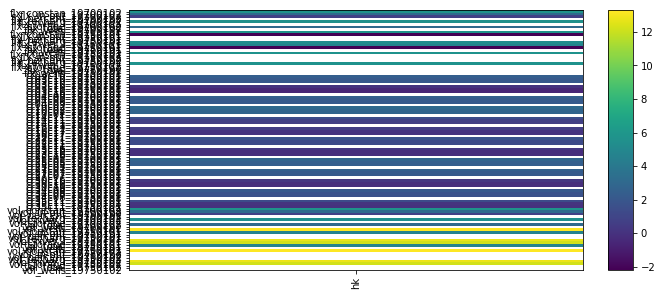

In [12]:
sih.plot_Jacobian(jac_simple)

## how about just the first 20 parameters?

/Users/mnfienen/Documents/GIT/GW1876/activities/freyberg_sensitivity_identifiability/sensitivity_identifiability_helper.py:54: RuntimeWarning: divide by zero encountered in log
  jcdata = np.log(np.abs(jac.df()))


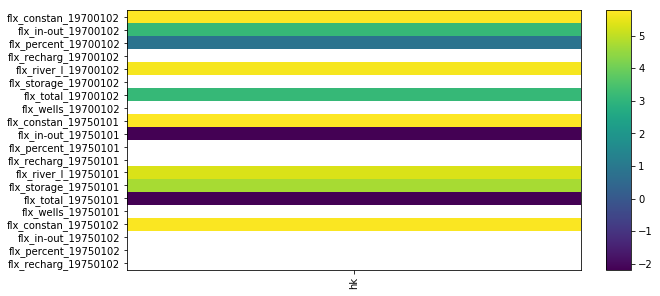

In [13]:
sih.plot_Jacobian(jac_simple[:20,:])

/Users/mnfienen/Documents/GIT/GW1876/activities/freyberg_sensitivity_identifiability/sensitivity_identifiability_helper.py:54: RuntimeWarning: divide by zero encountered in log
  jcdata = np.log(np.abs(jac.df()))


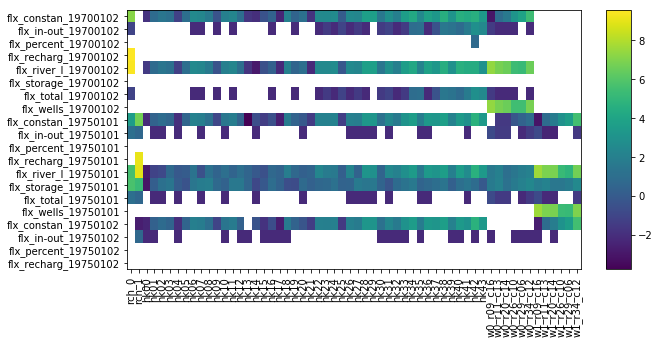

In [14]:
sih.plot_Jacobian(jac_complex[:20,:])

# Can be more informative to look at sensitivity spatially

In [15]:
print(jac_complex.row_names)

['flx_constan_19700102', 'flx_in-out_19700102', 'flx_percent_19700102', 'flx_recharg_19700102', 'flx_river_l_19700102', 'flx_storage_19700102', 'flx_total_19700102', 'flx_wells_19700102', 'flx_constan_19750101', 'flx_in-out_19750101', 'flx_percent_19750101', 'flx_recharg_19750101', 'flx_river_l_19750101', 'flx_storage_19750101', 'flx_total_19750101', 'flx_wells_19750101', 'flx_constan_19750102', 'flx_in-out_19750102', 'flx_percent_19750102', 'flx_recharg_19750102', 'flx_river_l_19750102', 'flx_storage_19750102', 'flx_total_19750102', 'flx_wells_19750102', 'cr03c10_19700101', 'cr03c10_19700102', 'cr03c10_19750101', 'cr03c10_19750102', 'cr03c16_19700101', 'cr03c16_19700102', 'cr03c16_19750101', 'cr03c16_19750102', 'cr04c09_19700101', 'cr04c09_19700102', 'cr04c09_19750101', 'cr04c09_19750102', 'cr10c02_19700101', 'cr10c02_19700102', 'cr10c02_19750101', 'cr10c02_19750102', 'cr14c11_19700101', 'cr14c11_19700102', 'cr14c11_19750101', 'cr14c11_19750102', 'cr16c17_19700101', 'cr16c17_19700102'

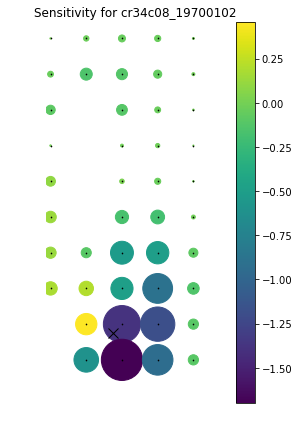

In [16]:
sih.plot_jacobian_spatial(jac_complex,'cr34c08_19700102');

In [17]:
with PdfPages('allsens.pdf') as ofp:
    for cob in jac_complex.row_names:
        if 'flx' not in cob and 'vol' not in cob:
            cf = sih.plot_jacobian_spatial(jac_complex, cob)
            ofp.savefig()
            plt.close('all')

# How about Composite Scaled Sensitivities
In the traditional, overdetermined regression world, CSS was a popular metric. CSS is Composite Scaled Sensitivitity.

In Hill and Tiedeman (2007) this is calculated as: 
## ${css_{j}=\sqrt{\left(\sum_{i-1}^{ND}\left(\frac{\partial y'_{i}}{\partial b_{j}}\right)\left|b_{j}\right|\sqrt{w_{ii}}\right)/ND}}$

In PEST, Doherty calculates it slightly differently in that scaling by the parameter values happens automatically when the parameter is subjected to a log-transform. This is due to a correction that must be made in calculating the Jacobian matrix and follows from the chain rule of derivatives.


In [19]:
la = pyemu.LinearAnalysis(jco=os.path.join(os.path.join(fs.WORKING_DIR_PP, 'freyberg_pp_jac.jcb')))

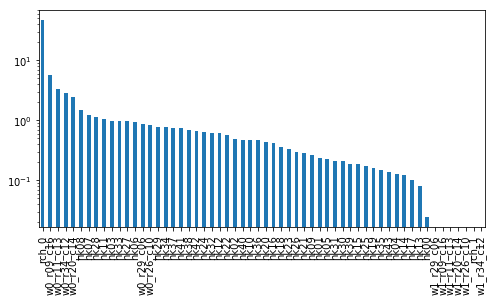

In [20]:
plt.figure(figsize=(8,4))
ax = la.get_par_css_dataframe()['pest_css'].sort_values(ascending=False).plot(kind='bar')
ax.set_yscale('log')

### Now let's consider correlation and posterior covariance

In [21]:
sc = pyemu.Schur(os.path.join(os.path.join(fs.WORKING_DIR_PP, 'freyberg_pp_jac.jcb')))
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df().head()

,rch_0,rch_1,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,...,w0_r20_c14,w0_r26_c10,w0_r29_c06,w0_r34_c12,w1_r09_c16,w1_r11_c13,w1_r20_c14,w1_r26_c10,w1_r29_c06,w1_r34_c12
rch_0,4.491356e+05,1.502401e-47,4.099568e+01,-1.302094e+02,-9.851756e+02,-1.626641e+03,-1.836089e+02,-2.962493e+02,-1.318492e+03,-2.469388e+03,...,-2.230339e+04,-7.418119e+03,-7.025338e+03,-2.422219e+04,-3.739020e-48,-1.845823e-48,-1.763085e-48,-3.327131e-49,-2.466268e-49,-1.531123e-48
rch_1,1.502401e-47,9.799090e-46,-1.207960e-51,1.321481e-50,-3.345374e-50,-1.230899e-49,-4.783226e-50,5.192461e-50,1.600510e-49,4.426064e-51,...,-1.743061e-49,-2.362503e-49,-3.515412e-49,-4.471106e-49,-1.093895e-46,-5.431374e-47,-5.165494e-47,-9.943228e-48,-7.498114e-48,-4.499639e-47
hk00,4.099568e+01,-1.207960e-51,1.153994e-01,2.498919e-01,-2.141140e+00,-4.578931e+00,-5.202611e-01,-2.226093e-01,-1.208721e+00,-5.525762e+00,...,2.771911e-01,-2.051104e-01,-4.716073e-01,-7.826829e-02,4.331631e-52,2.152916e-52,2.006588e-52,2.740229e-53,5.399045e-54,9.414993e-54
hk01,-1.302094e+02,1.321481e-50,2.498919e-01,1.100710e+01,2.796162e+00,-1.784109e+01,-2.311504e+00,9.455820e+00,3.799760e+01,5.524207e+00,...,-2.763357e+00,2.641151e+00,5.637407e+00,1.811643e+00,-5.233734e-51,-2.615897e-51,-2.414673e-51,-2.983096e-52,6.188757e-54,4.548452e-52
hk02,-9.851756e+02,-3.345374e-50,-2.141140e+00,2.796162e+00,4.772138e+01,7.872103e+01,8.443848e+00,1.047833e+01,4.810347e+01,1.182098e+02,...,-2.806320e+00,6.497989e+00,1.297996e+01,5.258103e+00,5.691878e-51,2.760457e-51,2.767784e-51,7.700365e-52,9.281711e-52,6.410998e-51


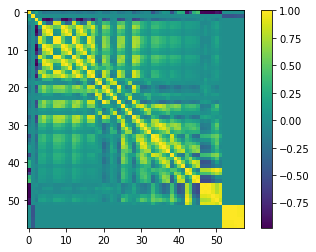

In [22]:
R = covar.to_pearson()
plt.imshow(R.df(), interpolation='nearest', cmap='viridis')
plt.colorbar()

In [24]:
cpar = 'hk10'
R.df().loc[cpar][np.abs(R.df().loc[cpar])>.5]

hk01    0.865684
hk02    0.527549
hk05    0.996146
hk06    0.998496
hk07    0.535670
hk10    1.000000
hk11    0.646770
hk14    0.948556
hk15    0.734204
hk18    0.631582
hk22    0.640792
hk23    0.720455
hk26    0.736650
hk27    0.732692
Name: hk10, dtype: float64

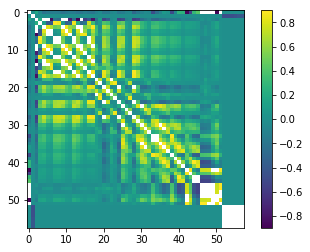

In [25]:
R_plot = R.df().as_matrix()
R_plot[np.abs(R_plot)>.9] = np.nan
plt.imshow(R_plot, interpolation='nearest', cmap='viridis')
plt.colorbar()